
**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---

# Trabajo práctico entregable - Parte 2

In [ ]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import ttest_ind
import scipy.stats as stats

seaborn.set_context('talk')

## Lectura del dataset

En la notebook 00 se explican los detalles de la siguiente sección.

In [ ]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

In [ ]:
df[:3]

,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,profile_studies_level_state,profile_career,profile_university,profile_specialization_courses,profile_open_source_contributions,profile_programming_as_hobby,work_role,tools_platform,tools_programming_languages,tools_frameworks,tools_data_bases,tools_qa_testing,tools_IDEs,tools_work_pc_os,tools_cellphone_os,work_on_call_duty,salary_on_call_duty_charge,work_on_call_duty_charge_type,work_contract_type,salary_monthly_BRUTO,salary_monthly_NETO,salary_in_usd,salary_satisfaction,salary_comparison_last_semester,salary_has_bonus,salary_bonus_tied_to,salary_inflation_adjustment_2020,salary_percentage_inflation_adjustment_2020,salary_month_last_inflation_adjustment,work_has_violence_situations,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city
0,Mujer,26,Argentina,Ciudad Autónoma de Buenos Aires,3.0,3.0,3.0,0,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, los pagó un empleador",No,Sí,Consultant,Ninguna,Ninguno,Ninguno,Ninguna,Ninguna,Ninguno,GNU/Linux,Android,No,0.0,Bruto,Full-Time,53000.0,43000.0,NaN,1,1,No,No recibo bono,No,0.0,0,En mi trabajo actual,Homosexual,NaN,NaN,501-1000,Servicios / Consultoría de Software / Digital,7,2,"Capacitaciones y/o cursos, Comidas pagas / sub...",NaN
1,Hombre,29,Argentina,Corrientes,5.0,2.0,2.0,4,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, de forma particular, Sí, los pagó un emple...",No,Sí,Developer,"Docker, Google Cloud Platform/App Engine","HTML, Javascript, Python","Django, jQuery","Informix, MySQL, PostgreSQL",Ninguna,"IPython / Jupyter, Sublime Text, Visual Studio...",GNU/Linux,Android,No,0.0,Bruto,Full-Time,79000.0,63000.0,NaN,2,2,Menos de un sueldo,Performance de la compañía,Uno,10.0,1,Jamás,Heterosexual,Visual,No,201-500,Otras industrias,8,9,"Horarios flexibles, Stock options / RSUs, Viát...",NaN
2,Mujer,22,Argentina,Ciudad Autónoma de Buenos Aires,2.0,0.0,0.0,0,Secundario,Completado,NaN,NaN,"Sí, de forma particular, Sí, los pagó un emple...",No,Sí,Infosec,"Linux, VMWare",Ninguno,Ninguno,Ninguna,Ninguna,Ninguno,Windows,iOS,No,0.0,Porcentaje de mi sueldo,Full-Time,160000.0,127000.0,NaN,3,3,Un sueldo,Performance individual,No,0.0,0,En un trabajo anterior,Bisexual o queer,NaN,No,2001-5000,Otras industrias,6,9,"Clases de gimnasia online, Comidas pagas / sub...",NaN


In [ ]:
df[['profile_gender', 'salary_monthly_NETO']].groupby('profile_gender').describe()

salary_monthly_NETO                ...                     
                             count          mean  ...       75%        max
profile_gender                                    ...                     
Hombre                      4944.0  98836.063558  ...  110000.0  2080000.0
Mujer                        908.0  73501.414465  ...   92000.0   800000.0
Otros                         31.0  95441.354839  ...  117500.0   380000.0

[3 rows x 8 columns]

In [ ]:
df[df.salary_monthly_NETO > 1000]\
  [['profile_gender', 'salary_monthly_NETO']].groupby('profile_gender').describe()

salary_monthly_NETO                 ...                     
                             count           mean  ...       75%        max
profile_gender                                     ...                     
Hombre                      4815.0  101481.624343  ...  110000.0  2080000.0
Mujer                        863.0   77328.913778  ...   93000.0   800000.0
Otros                         28.0  105660.714286  ...  122750.0   380000.0

[3 rows x 8 columns]

In [ ]:
alpha = 0.05

In [ ]:
#Eliminamos el percentil 95 del DS
k = 95
percentile95 = df['salary_monthly_NETO'].quantile(k/100)
df = df[df["salary_monthly_NETO"] < percentile95]


In [ ]:
#grupos de Hombre y otros, sin percentil 95. 
is_man = df.profile_gender == 'Hombre'
groupA = df[(df.salary_monthly_NETO > 1000) & is_man].salary_monthly_NETO
groupB = df[(df.salary_monthly_NETO > 1000) & ~is_man].salary_monthly_NETO

## Ejercicio 1: Estimación

**Consigna:**  Calcular una estimación puntual y un intervalo de confianza de nivel (1-alpha) para la resta entre la media del salario Neto para Hombres menos la media del salario Neto para otros géneros(diferencia de las medias entre el grupoA y grupoB). 
¿Cómo se relaciona este intervalo de confianza con el test de hipótesis?

In [ ]:
#estimación puntual
resta_medias=groupA.mean() - groupB.mean()

Previo a realizar los test de hipótesis corroboramos gráficamente, post eliminación del percentil 95, que la distribución muestral tiene un comportamiento normal. 

Text(0.5, 1.0, 'GroupB')

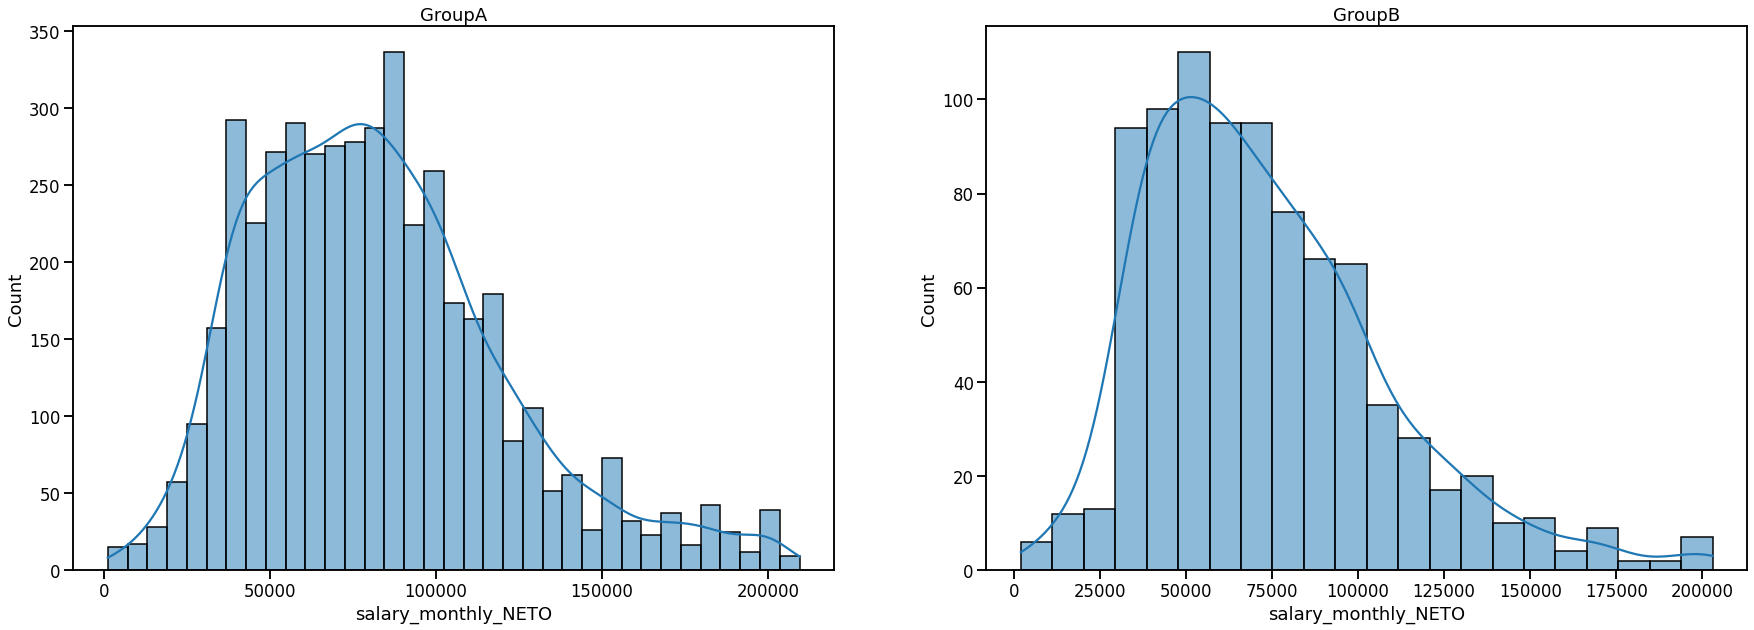

In [ ]:
#histograma de los dos grupos
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
sns.histplot(data=groupA,ax=axs[0],kde= True).set_title('GroupA')
sns.histplot(data=groupB,ax=axs[1],kde= True).set_title('GroupB')

Refrozamos el histrograma con un qqplot de la muestra vs la distribución normal, luego de normalización de la muestra. 

In [1]:
#descomentar a continuación por si hace falta instalar qqplot de seaborn
#!pip install seaborn_qqplot

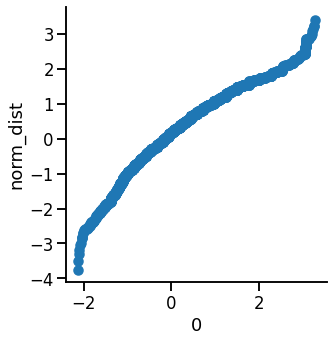

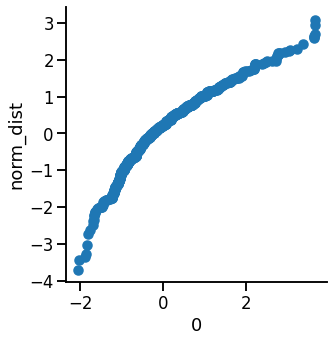

In [ ]:
from sklearn.preprocessing import StandardScaler
from seaborn_qqplot import pplot
from scipy.stats import norm
##qqplot vs distribución normal
#normalización de los datos
#1.reshape a Group a un array 2D
groupA_reshape=groupA.values.reshape(-1,1)
groupB_reshape=groupB.values.reshape(-1,1)
#2.normalización con resta y división por varianza muestral, usando StandardScaler
groupA_norm=StandardScaler().fit_transform(groupA_reshape)
groupB_norm=StandardScaler().fit_transform(groupB_reshape)
#Graficamos los qqplot de los datos normalizados vs distrib. normal
#1.pplot requiere un dataframe y volvemos los Group noramlizados (que son numpy array) a un DF de pandas.
groupA_norm_df=pd.DataFrame(groupA_norm)#.rename(columns={ groupA_norm_df.columns[0]: "GroupA" }, inplace = True)
groupB_norm_df=pd.DataFrame(groupB_norm)
#2.graficamos qqplot
pplot(groupA_norm_df,x=groupA_norm_df.columns[0],y=norm,kind='qq',height=5)
pplot(groupB_norm_df,x=groupB_norm_df.columns[0],y=norm,kind='qq',height=5)


A continuación procedemos a calcular el estadístico t, p e intervalo de confianza suponiendo que la población es normal y varianza iguales. 

In [ ]:
#intervalo de confianza suponiendo población con distribución normal y varianza iguales. .
#cálculo del intervalo: (X1-X2)+-t.95(df) * std_N1N2 * sqrt(1/N1 + 1/N2)
from scipy.stats import t
from math import sqrt
#primer término
N1=len(groupA)
N2=len(groupB)
df=N1+N2-2
#valor de t para alfa=0.05. 
t_val = t.ppf([0.975], df)
#segundo término
std_groupA = groupA.values.std()
std_groupB = groupB.values.std()
std_GAGB = sqrt(((N1 - 1)*(std_groupA)**2 + (N2 - 1)*(std_groupB)**2) / df) 
#cálculo de intervalo
print(f'Límite derecho para el estadístico t:{t_val}')
IC=t_val*std_GAGB*sqrt(1/N1 + 1/N2)
print('Resta de las medias: {}'.format(resta_medias))
print(f'Intervalo: {str(resta_medias - IC)} - {str(resta_medias)} - {str(resta_medias + IC)}')

Límite derecho para el estadístico t:[1.96040339]
Resta de las medias: 9549.190428936272
Intervalo: [6818.58855226] - 9549.190428936272 - [12279.79230561]


Observando los resultados, podemos concluir que, con un intervalo de confianza del 95%, la diferencia de salario neto entre "hombres" y "otros" puede variar entre aprox. 6.819 pesos y 12.280 pesos. Para verificar si realmente las medias son iguales o distintas, habría que proceder con un test de hipótesis y calcular el valor p. 


## Ejercicio 2: Test de hipótesis



### 2.1 Formalización

Describir formalmente los distintos compenentes de un test de hipótesis para comprobar si la distribución de los salarios es distinta entre los grupos A y B.

**Hipótesis Nula**

H_0= diferencia de medias entre Grupo A y Grupo B es igual

**Estadístico (Pivote)**
  * Identificar el estadístico

T~t (con n1+n2-2 grados de libertad)

  * Escribir qué distribución tiene bajo $H_0$

Se mantiene la misma bajo las muestras, que se supone normal. 

### 2.2 P-valor

1. Calcule el p-valor y decida si rechazar o no la hipótesis nula.
2. Interprete el resultado.
3. Los dos grupos de nuestra muestra tienen tamaños muy distintos. ¿Esto afecta al tests?

Links útiles:
* [Test de hipótesis usando scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)
* [Test de Welch](http://daniellakens.blogspot.com/2015/01/always-use-welchs-t-test-instead-of.html)


En el cálculo a continuación verificamos que el estadísticos t es superior al límite calculado anteriormente (1.96). Además p es muy inferior a alfa 0.05. Ambos estadísticos nos permiten rechazar la hipótesis nula. 

In [ ]:
stats.ttest_ind(groupA, groupB, equal_var = True)

Ttest_indResult(statistic=6.854537264524475, pvalue=7.953631433867233e-12)

### [Opcional] 2.3 Potencia del test

Nuestra muestra, ¿era lo suficientemente grande para detectar si existe o no una diferencia entre los grupos?

1. Utilice la función `tt_ind_solve_power` para calcular el tamaño necesario de la muestra para un poder estadístico de 0.8, 0.9 y 0.95, asumiendo una significancia estadística de 0.05.
2. ¿Cómo intepretan el poder estadístico de un test? Dado su conocimiento de dominio sobre los datos, ¿les parece que esta muestra es lo suficientemente grande para ser representativo de la tendencia general? ¿y para utilizarlo en un juicio penal contra una empresa XX por una causa de discriminación?

[Documentación](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.tt_ind_solve_power.html)

NOTA: este análisis debería hacerse ANTES de recolectar los datos.

Para cualquier poder estadístico 0.8,0.9 o 0.95, el tamaño de las muestras de los dos grupos es suficiente. A mayor poder, hay mayor exigencia con respecto al tamaño de las muestras. 

Desde el punto de vista estadístico las muestras son representativas. Frente a un juicio penal deberían presentarse este análisis, teniendo en cuenta por supuesto la muestras para ese juicio, complementando el conjunto de pruebas que se tengan para el juicio. 

In [ ]:
from statsmodels.stats.power import tt_ind_solve_power

In [ ]:
effect_size = (groupA.mean() - groupB.mean()) / groupB.std()
# nobs1=None  - What we want to know
# nobs1 The number of observations of sample two is ratio times the size of sample 1, i.e. nobs2 = nobs1 * ratio
alpha = 0.05
ratio = len(groupB) / len(groupA)

In [ ]:
#Power is the probability that the test correctly rejects the Null Hypothesis if the Alternative Hypothesis is true.
power=0.95

In [ ]:
nobs1=tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=ratio)

In [ ]:
print('# sample 1:', nobs1)
print('# sample 2:',nobs1*ratio)

# sample 1: 1063.928130706369
# sample 2: 205.64106789663637


## Ejercicio 3: Comunicación y visualización

Hemos seleccionado para este ejercicio la comunicación a través de un tweet del estudio realizado sobre las variables categóricas Años de Exp y Nivel de Estudio y su salario neto. Lo consideramos interesante porque refuerza el rol de las universidades y carreras de grado y postgrado por un lado, y por el otro que las empresas están valorando económicamente el nivel de estudio y los años de experiencia.

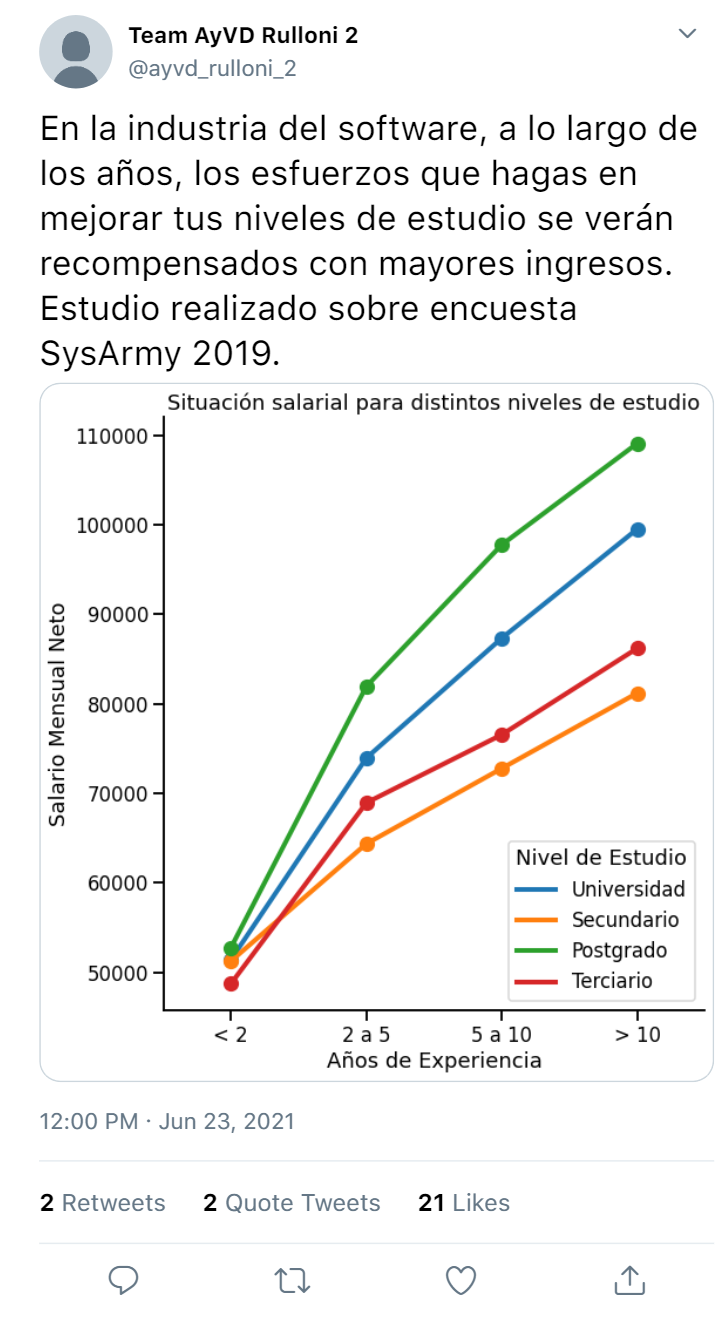